# CDK Binding Affinity

In [97]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from matplotlib.colors import ListedColormap



### Columns

- `BindingDB Ligand Name`: (Text) name of ligand. 

- `Target Name`: (Text) Name of the target (indicate deletions (e.g., a truncated sequence) or mutations (e.g., Met results changed for the sake of stability)). For example, [262-930, L692P] means the protein includes residues 262-930 of the full sequence and Leu 692 is replaced by Pro. 

- `Target Source Organism According to Curator or DataSource`: (Text) Organism associated with the protein target. 



##### Measure of Binding Affinity:

- `Ki (nM)`: (Real>0) Inhibition Constant; concentration of the inhibitor required to reduce the activity of an enzyme by half in the absence of the substrate. The lower the Ki value, the stronger the inhibitor binds to its target.

- `IC50 (nM)`: (Real >0) (Values are occasionally reported as “>X”, where X is Real, following the source document) The concentration of the inhibitor that reduces the enzyme activity by 50%. Same as Ki but corrected for experimental condition, making it more accurate and independent of substrate concentration.

- `Kd (nM)`: (Real >0) (Values are occasionally reported as “>X”, where X is Real, following the source document.) Dissociation Constant; It represents the concentration of the ligand at which half of the available binding sites on the target are occupied. Lower Kd, higher binding affinity.

- `EC50 (nM)`: (Real >0) (Values are occasionally reported as “>X”, where X is Real, following the source document.) Concentration of a drug or ligand required to produce 50% of its maximum effect.

- `kon (M-1-s-1)`: (Real >0) Assocition rate constant; Measure of the rate at which a ligand binds to its target, how quickly the ligand and the target come together to form a complex.

- `Koff(s-1)`

- `pH`

- `Temp ( C)`



##### Chain of the Binding: 

- `Number of Protein Chains in Target (>1 implies a multichain complex)`: (1,2 or 3) The following information will be provided, if available, for each chain in the protein. (indicated by .n for the n+1 chain)

- `BindingDB Target Chain Sequence`:(text) sequences of AAs. 

- `UniProt (SwissProt) Entry Name of Target Chain`: (text) name of the target chain.

Or: 

- `UniProt (TrEMBL) Entry Name of Target Chain`: (text) name of the target chain. 




In [98]:
df = pd.read_csv('data/BindingDB_col_cleaned.tsv', sep='\t') # loading of the cleaned data (CDKs selected and columns necessary for analysis selected)
df.head()

,Ligand SMILES,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),...,Number of Protein Chains in Target (>1 implies a multichain complex),BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,UniProt (TrEMBL) Entry Name of Target Chain,BindingDB Target Chain Sequence.1,UniProt (SwissProt) Entry Name of Target Chain.1,UniProt (TrEMBL) Entry Name of Target Chain.1,BindingDB Target Chain Sequence.2,UniProt (SwissProt) Entry Name of Target Chain.2,UniProt (TrEMBL) Entry Name of Target Chain.2
0,COc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1,3-((4-Methoxyphenyl)-amino)-4-((3-chlorophenyl...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,5800,NaN,NaN,NaN,NaN,...,2,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN
1,Oc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1,3-((4-Hydroxyphenyl)amino)-4-((3-chlorophenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,>1000,NaN,NaN,NaN,NaN,...,2,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN
2,COc1cccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)c1,3-((3-Methoxyphenyl)amino)-4-((3-chlorophenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,4300,NaN,NaN,NaN,NaN,...,2,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN
3,Oc1cccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)c1,3-((3-Hydroxyphenyl)amino)-4-((3-chlorophenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,3000,NaN,NaN,NaN,NaN,...,2,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN
4,CC(C)(C)OC(=O)Nc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl...,3-((4-(N-BOC-amino)phenyl)amino)-4-((3-chlorop...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,NaN,57000,NaN,NaN,NaN,NaN,...,2,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,NaN,MALRVTRNSKINAENKAKINMAGAKRVPTAPAATSKPGLRPRTALG...,CCNB1_HUMAN,NaN,NaN,NaN,NaN


In [99]:
#The number of different CDKs
df['Target Name'].unique().size

47

In [100]:
#The number of different Ligands
df['BindingDB Ligand Name'].unique().size

4577

In [101]:
# Does Ligand-CDKs pairs are unique ?
X = df.groupby('Target Name').size()
print(X)

#There is repeats. For example, the CDKs 'Cyclin-A2/Cyclin-dependent kinase 2' has 5748 rows (>number of ligands), inducing repeats. 
# But maybe the constant of affinity measurred is different?

## Life Science: The name 'Cyclin-A2/Cyclin-dependent kinase 2' indicates that this kinase 
#               (CDK2) is typically associated with the cyclin A2 protein

Target Name
Cyclin-A1/Cyclin-dependent kinase 2                                               354
Cyclin-A2 [171-432]/Cyclin-dependent kinase 2                                     840
Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 [F82H,L83V,H84D,K98T]                12
Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 [F82H,L83V,H84D]                     12
Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 [F82H]                                6
Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 [K89T]                               12
Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 [L83V,H84D]                           6
Cyclin-A2 [177-432]/Cyclin-dependent kinase 2                                     132
Cyclin-A2/Cyclin-dependent kinase 1                                                18
Cyclin-A2/Cyclin-dependent kinase 2                                              5748
Cyclin-H/Cyclin-dependent kinase 7                                                174
Cyclin-T1/Cyclin-dependent kinase 9       

In [102]:
# Number of ligands measure for the case of the CDK 'Cyclin-A2/Cyclin-dependent kinase 2'
df[df['Target Name']=='Cyclin-A2/Cyclin-dependent kinase 2']['BindingDB Ligand Name'].unique().size

870

In [103]:
df[df['Target Name']=='Cyclin-A2/Cyclin-dependent kinase 2'].groupby('BindingDB Ligand Name').size()

BindingDB Ligand Name
(12Z)-12-({[4-(methanesulfonylmethyl)phenyl]amino}methylidene)-3-thia-5,10-diazatricyclo[7.3.0.0^{2,6}]dodeca-1,4,6,8-tetraen-11-one::8-({4-[(Methylsulfonyl)methyl]anilino}methylene)-6,8-dihydro-7H-[1,3]thiazolo[5,4-e]indol-7-one::Oxindole-Based Inhibitor 107                                             6
(12Z)-12-{[(4-methanesulfonylphenyl)amino]methylidene}-3-thia-5,10-diazatricyclo[7.3.0.0^{2,6}]dodeca-1,4,6,8-tetraen-11-one::8-{[4-(Methylsulfonyl)anilino]methylene}-6,8-dihydro-7H-[1,3]thiazolo[5,4-e]indol-7-one::Oxindole-Based Inhibitor 102                                                             6
(12Z)-12-{[(4-{[2-(2-hydroxyethoxy)ethyl]sulfamoyl}phenyl)amino]methylidene}-3-thia-5,10-diazatricyclo[7.3.0.0^{2,6}]dodeca-1,4,6,8-tetraen-11-one::N-[2-(2-Hydroxyethoxy)ethyl]-4-{[(7-oxo-6,7-dihydro-8H-[1,3]thiazolo[5,4-e]indol-8-ylidene)methyl]amino}-benzenesulfonamide::Oxindole-Based Inhibitor 87    6
(15R,18R)-28-oxa-4,14,19-triazaoctacyclo[12.11.2.1^{15,18}.0

In [104]:
# Do we have different measurments? 
Target ='Cyclin-A2/Cyclin-dependent kinase 2'
# I took the first ligand of the previous result, beacause there is 6 different rows
Ligand= '(12Z)-12-({[4-(methanesulfonylmethyl)phenyl]amino}methylidene)-3-thia-5,10-diazatricyclo[7.3.0.0^{2,6}]dodeca-1,4,6,8-tetraen-11-one::8-({4-[(Methylsulfonyl)methyl]anilino}methylene)-6,8-dihydro-7H-[1,3]thiazolo[5,4-e]indol-7-one::Oxindole-Based Inhibitor 107'
TargetLigand=df[(df['BindingDB Ligand Name']== Ligand) & (df['Target Name']==Target)]
TargetLigand


,Ligand SMILES,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),...,Number of Protein Chains in Target (>1 implies a multichain complex),BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,UniProt (TrEMBL) Entry Name of Target Chain,BindingDB Target Chain Sequence.1,UniProt (SwissProt) Entry Name of Target Chain.1,UniProt (TrEMBL) Entry Name of Target Chain.1,BindingDB Target Chain Sequence.2,UniProt (SwissProt) Entry Name of Target Chain.2,UniProt (TrEMBL) Entry Name of Target Chain.2
3251,CS(=O)(=O)Cc1ccc(cc1)N=CC1C(=O)Nc2ccc3ncsc3c12,(12Z)-12-({[4-(methanesulfonylmethyl)phenyl]am...,Cyclin-A2/Cyclin-dependent kinase 2,Homo sapiens,NaN,50,NaN,NaN,NaN,NaN,...,2,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,NaN,MLGNSAPGPATREAGSALLALQQTALQEDQENINPEKAAPVQQPRT...,CCNA2_HUMAN,NaN,NaN,NaN,NaN
12000,CS(=O)(=O)Cc1ccc(cc1)N=CC1C(=O)Nc2ccc3ncsc3c12,(12Z)-12-({[4-(methanesulfonylmethyl)phenyl]am...,Cyclin-A2/Cyclin-dependent kinase 2,Homo sapiens,NaN,50,NaN,NaN,NaN,NaN,...,2,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,NaN,MLGNSAPGPATREAGSALLALQQTALQEDQENINPEKAAPVQQPRT...,CCNA2_HUMAN,NaN,NaN,NaN,NaN
20749,CS(=O)(=O)Cc1ccc(cc1)N=CC1C(=O)Nc2ccc3ncsc3c12,(12Z)-12-({[4-(methanesulfonylmethyl)phenyl]am...,Cyclin-A2/Cyclin-dependent kinase 2,Homo sapiens,NaN,50,NaN,NaN,NaN,NaN,...,2,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,NaN,MLGNSAPGPATREAGSALLALQQTALQEDQENINPEKAAPVQQPRT...,CCNA2_HUMAN,NaN,NaN,NaN,NaN
29498,CS(=O)(=O)Cc1ccc(cc1)N=CC1C(=O)Nc2ccc3ncsc3c12,(12Z)-12-({[4-(methanesulfonylmethyl)phenyl]am...,Cyclin-A2/Cyclin-dependent kinase 2,Homo sapiens,NaN,50,NaN,NaN,NaN,NaN,...,2,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,NaN,MLGNSAPGPATREAGSALLALQQTALQEDQENINPEKAAPVQQPRT...,CCNA2_HUMAN,NaN,NaN,NaN,NaN
38247,CS(=O)(=O)Cc1ccc(cc1)N=CC1C(=O)Nc2ccc3ncsc3c12,(12Z)-12-({[4-(methanesulfonylmethyl)phenyl]am...,Cyclin-A2/Cyclin-dependent kinase 2,Homo sapiens,NaN,50,NaN,NaN,NaN,NaN,...,2,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,NaN,MLGNSAPGPATREAGSALLALQQTALQEDQENINPEKAAPVQQPRT...,CCNA2_HUMAN,NaN,NaN,NaN,NaN
46996,CS(=O)(=O)Cc1ccc(cc1)N=CC1C(=O)Nc2ccc3ncsc3c12,(12Z)-12-({[4-(methanesulfonylmethyl)phenyl]am...,Cyclin-A2/Cyclin-dependent kinase 2,Homo sapiens,NaN,50,NaN,NaN,NaN,NaN,...,2,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,NaN,MLGNSAPGPATREAGSALLALQQTALQEDQENINPEKAAPVQQPRT...,CCNA2_HUMAN,NaN,NaN,NaN,NaN


In [105]:
unique_rows = TargetLigand.drop_duplicates()
unique_rows

# IT IS ONLY DUPLICATES OF ROWS.


,Ligand SMILES,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),...,Number of Protein Chains in Target (>1 implies a multichain complex),BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,UniProt (TrEMBL) Entry Name of Target Chain,BindingDB Target Chain Sequence.1,UniProt (SwissProt) Entry Name of Target Chain.1,UniProt (TrEMBL) Entry Name of Target Chain.1,BindingDB Target Chain Sequence.2,UniProt (SwissProt) Entry Name of Target Chain.2,UniProt (TrEMBL) Entry Name of Target Chain.2
3251,CS(=O)(=O)Cc1ccc(cc1)N=CC1C(=O)Nc2ccc3ncsc3c12,(12Z)-12-({[4-(methanesulfonylmethyl)phenyl]am...,Cyclin-A2/Cyclin-dependent kinase 2,Homo sapiens,NaN,50,NaN,NaN,NaN,NaN,...,2,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,NaN,MLGNSAPGPATREAGSALLALQQTALQEDQENINPEKAAPVQQPRT...,CCNA2_HUMAN,NaN,NaN,NaN,NaN


In [106]:
#Cleaning of df by supressing duplicate rows.
df_cleaned = df.drop_duplicates()
df_cleaned.shape

# There may be different features in BindingDB, but we skipped columns such as 'authors of the experiment'. 
# Many authors and experiments may have been conducted with the same ligand-CDK pair.

(8227, 22)

In [107]:
Y = df_cleaned.groupby('Target Name').size()
print(Y)

# Differences between 'Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 [K89T]' and 
# 'Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 [L83V,H84D]' ?
## YES: it is the same CDK ('Cyclin-A2 [171-432]/Cyclin-dependent kinase 2') but with mutations. 
## For the first: The Amino Acid 'K', is replace by a 'T' at the 89th Amino acid of the sequence

Target Name
Cyclin-A1/Cyclin-dependent kinase 2                                                59
Cyclin-A2 [171-432]/Cyclin-dependent kinase 2                                     138
Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 [F82H,L83V,H84D,K98T]                 2
Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 [F82H,L83V,H84D]                      2
Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 [F82H]                                1
Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 [K89T]                                2
Cyclin-A2 [171-432]/Cyclin-dependent kinase 2 [L83V,H84D]                           1
Cyclin-A2 [177-432]/Cyclin-dependent kinase 2                                      22
Cyclin-A2/Cyclin-dependent kinase 1                                                 3
Cyclin-A2/Cyclin-dependent kinase 2                                               893
Cyclin-H/Cyclin-dependent kinase 7                                                 29
Cyclin-T1/Cyclin-dependent kinase 9       

### Formating values of Binding Affinity constant 

The values for Ki, Kd, IC50... can take forms like >100 or 2e+5 that need to be transformed to be analysed

In [108]:
# Fonction 'clean' to remove the characters > and <, remove the spaces and convert the strings into integers
def clean(ki, patern=['<', '>']):
    ki = str(ki).replace(patern[0], '')
    ki = str(ki).replace(patern[1], '')
    ki = ki.strip()       
    try:
        ki = int(ki)
    except ValueError:  
        ki = None
    return (ki)

### Binding Affinity constant ditribution 
- Ki (nM):

In [109]:
Ki_cleaned = pd.DataFrame(df_cleaned['Ki (nM)'].apply(lambda ki: clean(ki))) # cleaning of the Ki values
Ki_cleaned['Target Name'] = df['Target Name']
Ki_cleaned['BindingDB Ligand Name'] = df['BindingDB Ligand Name']
Ki_cleaned = Ki_cleaned.dropna(axis=0) # deleting all the NaN values
Ki_cleaned.head()

,Ki (nM),Target Name,BindingDB Ligand Name
263,5000.0,Cyclin-dependent kinase 1/G2/mitotic-specific ...,6-(cyclohexylmethoxy)-9H-purin-2-amine::CHEMBL...
266,2500.0,Cyclin-dependent kinase 1/G2/mitotic-specific ...,"2,6-Diamino-4-cyclohexylmethoxy-5-nitrosopyrim..."
268,12000.0,Cyclin-A2 [171-432]/Cyclin-dependent kinase 2,6-(cyclohexylmethoxy)-9H-purin-2-amine::CHEMBL...
271,1300.0,Cyclin-A2 [171-432]/Cyclin-dependent kinase 2,"2,6-Diamino-4-cyclohexylmethoxy-5-nitrosopyrim..."
3256,6500.0,Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,2-Anilino-4-(thiazol-5-yl)pyrimidine deriv. 8:...


In [110]:
Ki_cleaned.describe()

,Ki (nM)
count,260.000000
mean,2778.834615
std,5649.197769
min,1.000000
25%,69.750000
50%,300.000000
75%,1357.500000
max,20000.000000


Discuss: 50% of the values are <300. A Ki<300 represents a strong or moderate affinity. There is outliers (Ki equal to 20000) that represents no binding affinity. 

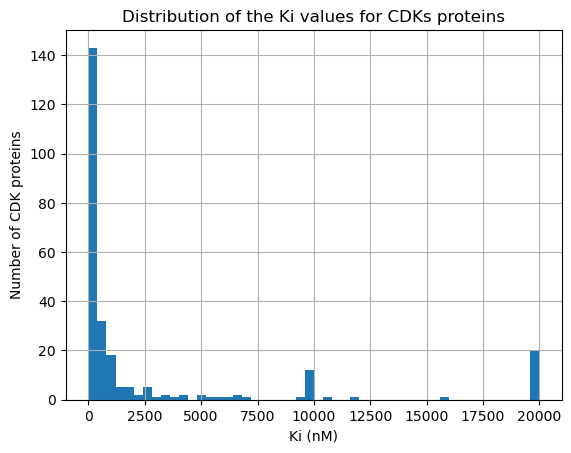

In [111]:
plt.title('Distribution of the Ki values for CDKs proteins')
plt.xlabel('Ki (nM)')
plt.ylabel('Number of CDK proteins')
Ki_cleaned['Ki (nM)'].hist(bins=50)
plt.show()

- IC50 (nM):

In [112]:
# 45'822 rows have IC50 value, 6822 of them contain < and 13476 contain >
# we should do samples to put the values into ranges => not done yet because maybe not useful... instead the same technique as above is performed

IC50_cleaned = pd.DataFrame(df_cleaned['IC50 (nM)'].apply(lambda ic: clean(ic)))
IC50_cleaned[IC50_cleaned > 20000] = np.nan # some very high values make the distribution not readable and relevant so we decided to remove them
IC50_cleaned['Target Name'] = df['Target Name']
IC50_cleaned['BindingDB Ligand Name'] = df['BindingDB Ligand Name']
IC50_cleaned = IC50_cleaned.dropna(axis=0)


In [113]:
IC50_cleaned.describe()

,IC50 (nM)
count,5956.000000
mean,2849.751175
std,5285.661834
min,1.000000
25%,35.000000
50%,240.000000
75%,2300.000000
max,20000.000000


discuss: same idea, almost the same value of the 50th percentile.

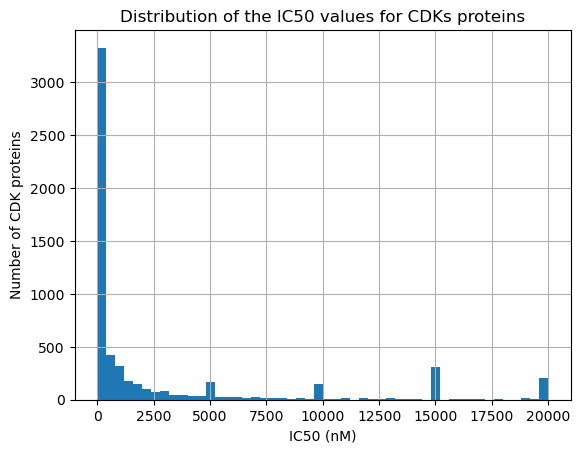

In [114]:
plt.title('Distribution of the IC50 values for CDKs proteins')
plt.xlabel('IC50 (nM)')
plt.ylabel('Number of CDK proteins')
IC50_cleaned['IC50 (nM)'].hist(bins=50)
plt.show()

- Kd (nM):

In [115]:
# 3552 rows have Kd value and 2058 Kd are equal to >100000 
Kd_cleaned = pd.DataFrame(df_cleaned['Kd (nM)'].apply(lambda kd: clean(kd)))
Kd_cleaned['Target Name'] = df['Target Name']
Kd_cleaned['BindingDB Ligand Name'] = df['BindingDB Ligand Name']
Kd_cleaned = Kd_cleaned.dropna(axis=0)

In [116]:
Kd_cleaned.describe()

,Kd (nM)
count,423.000000
mean,61653.198582
std,47635.468367
min,8.000000
25%,982.500000
50%,100000.000000
75%,100000.000000
max,100000.000000


Discuss: More than 50% of the values is equal to 100000 (very weak binding affinity).

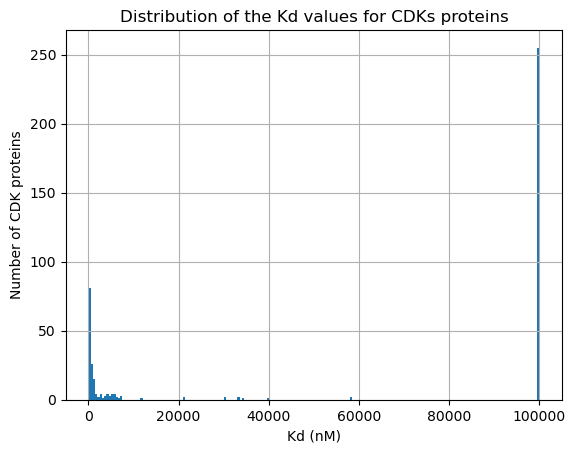

In [117]:
plt.title('Distribution of the Kd values for CDKs proteins')
plt.xlabel('Kd (nM)')
plt.ylabel('Number of CDK proteins')
Kd_cleaned['Kd (nM)'].hist(bins=200)
plt.show()

- EC50 (nM):

In [118]:
EC50_cleaned = df_cleaned['EC50 (nM)'].dropna()
print(EC50_cleaned)

4548    70.0
Name: EC50 (nM), dtype: float64


Discuss: There is only 1 value of EC50, all equals to 70. It is probabybly not exploitable.

- Number of target chains:

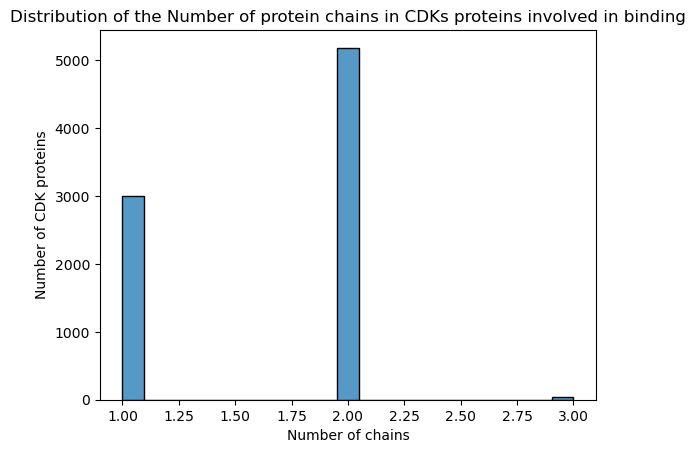

In [119]:
Number_of_chain_cleaned=df_cleaned['Number of Protein Chains in Target (>1 implies a multichain complex)'].dropna()
plt.title('Distribution of the Number of protein chains in CDKs proteins involved in binding')
plt.xlabel('Number of chains')
plt.ylabel('Number of CDK proteins')
sns.histplot(Number_of_chain_cleaned)
plt.show()


## Categorisation of binding affinities

In [120]:
def interaction_map(df, measure):

    df_copy = df.copy()

    # Créer un dictionnaire pour attribuer des valeurs numériques aux interactions
    interaction = {'Weak_interaction': 1, 'Moderate_interaction': 2, 'Strong_interaction': 3}

    # Créer la colonne 'Interaction' en fonction des colonnes Strong, Moderate et Weak
    df_copy['Interaction'] = df_copy.apply(
        lambda row: interaction['Weak_interaction'] if row['Weak_interaction'] == 1 else 
                    (interaction['Moderate_interaction'] if row['Moderate_interaction'] == 1 else 
                    interaction['Strong_interaction']),
        axis=1)

    # Créer un tableau croisé dynamique (pivot table)
    pivot_table = df_copy.pivot_table(index='Target Name', 
                                 columns='BindingDB Ligand Name', 
                                 values='Interaction', 
                                 aggfunc='first')  # Utiliser 'first' pour garantir qu'il y a une seule valeur pour chaque paire

    # Définir un colormap avec des nuances de rouge
    custom_palette = ListedColormap(['#FFCCCC', '#FF6666', '#990000'])  # Rouge clair, rouge, rouge foncé

    # Créer la heatmap avec un contrôle de l'échelle de couleur
    plt.figure(figsize=(17, 2))
    sns.heatmap(pivot_table, annot=False, cmap=custom_palette, linewidths=0.1, square=True, xticklabels=False, yticklabels=False, cbar_kws={'ticks': [1, 2, 3]})

    # Ajouter la légende personnalisée
    cbar = plt.gca().collections[0].colorbar
    cbar.set_ticks([1, 2, 3])
    cbar.set_ticklabels(['Weak interaction', 'Moderate interaction', 'Strong interaction'])

    # Ajouter le titre et les étiquettes
    plt.title(f"Heatmap of ligands and targets interactions based on their {measure} values")
    plt.xlabel('Ligands')
    plt.ylabel('Targets')

    plt.show()


- **Ki**: We consider the interaction between the target (CDK) and the ligand to be: 
1) Strong if Ki < 10nM
2) Moderated if 10nM < Ki < 1'000nM
3) Weak if Ki > 1'000nM

In [121]:
Ki_cleaned['Strong_interaction'] = Ki_cleaned['Ki (nM)']<=10
Ki_cleaned['Moderate_interaction'] = (Ki_cleaned['Ki (nM)']>10) & (Ki_cleaned['Ki (nM)']<=1000)
Ki_cleaned['Weak_interaction'] = Ki_cleaned['Ki (nM)']>1000

Ki_cleaned.head(2)

,Ki (nM),Target Name,BindingDB Ligand Name,Strong_interaction,Moderate_interaction,Weak_interaction
263,5000.0,Cyclin-dependent kinase 1/G2/mitotic-specific ...,6-(cyclohexylmethoxy)-9H-purin-2-amine::CHEMBL...,False,False,True
266,2500.0,Cyclin-dependent kinase 1/G2/mitotic-specific ...,"2,6-Diamino-4-cyclohexylmethoxy-5-nitrosopyrim...",False,False,True


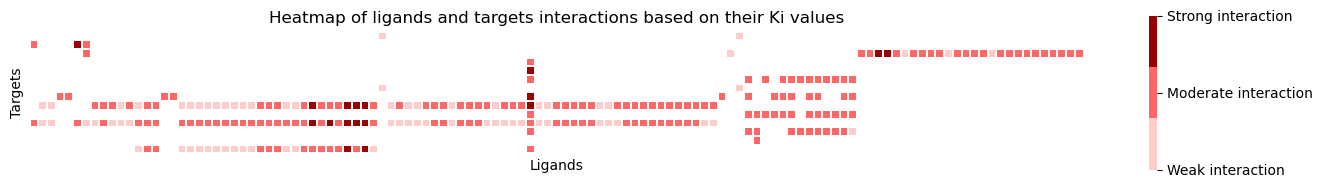

In [122]:
interaction_map(Ki_cleaned, 'Ki')

- **IC50**: We consider the interaction between the target (CDK) and the ligand to be: 
1) Strong if IC50 < 10nM
2) Moderated if 10nM < IC50 < 1'000nM
3) Weak if IC50 > 1'000nM

In [123]:
IC50_cleaned['Strong_interaction'] = IC50_cleaned['IC50 (nM)']<=10
IC50_cleaned['Moderate_interaction'] = (IC50_cleaned['IC50 (nM)']>10) & (IC50_cleaned['IC50 (nM)']<=1000)
IC50_cleaned['Weak_interaction'] = IC50_cleaned['IC50 (nM)']>1000

IC50_cleaned.head(5)

,IC50 (nM),Target Name,BindingDB Ligand Name,Strong_interaction,Moderate_interaction,Weak_interaction
0,5800.0,Cyclin-dependent kinase/G2/mitotic-specific cy...,3-((4-Methoxyphenyl)-amino)-4-((3-chlorophenyl...,False,False,True
1,1000.0,Cyclin-dependent kinase/G2/mitotic-specific cy...,3-((4-Hydroxyphenyl)amino)-4-((3-chlorophenyl)...,False,True,False
2,4300.0,Cyclin-dependent kinase/G2/mitotic-specific cy...,3-((3-Methoxyphenyl)amino)-4-((3-chlorophenyl)...,False,False,True
3,3000.0,Cyclin-dependent kinase/G2/mitotic-specific cy...,3-((3-Hydroxyphenyl)amino)-4-((3-chlorophenyl)...,False,False,True
5,10000.0,Cyclin-dependent kinase/G2/mitotic-specific cy...,3-((4-Aminophenyl)amino)-4-((3-chlorophenyl)am...,False,False,True


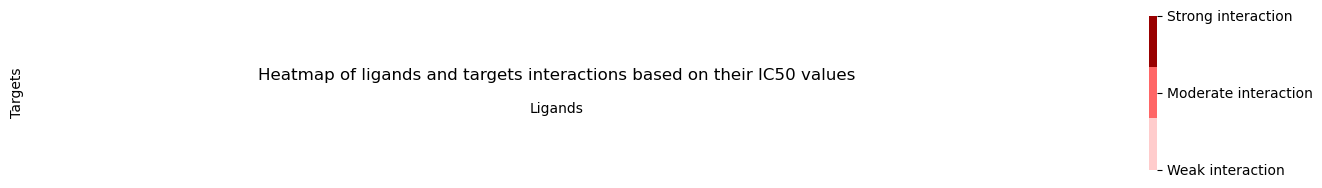

In [124]:
interaction_map(IC50_cleaned, 'IC50')

- **Kd**: We consider the interaction between the target (CDK) and the ligand to be: 
1) Strong if Kd < 100nM
2) Moderated if 100nM < Kd < 10'000nM
3) Weak if Kd > 10'000nM

In [129]:
Kd_cleaned['Strong_interaction'] = Kd_cleaned['Kd (nM)']<=100
Kd_cleaned['Moderate_interaction'] = (Kd_cleaned['Kd (nM)']>10) & (Kd_cleaned['Kd (nM)']<=10000)
Kd_cleaned['Weak_interaction'] = Kd_cleaned['Kd (nM)']>10000

Kd_cleaned.head(5)

,Kd (nM),Target Name,BindingDB Ligand Name,Strong_interaction,Moderate_interaction,Weak_interaction
4115,1300.0,Cyclin-dependent kinase 11B,1-[4-(3-amino-1H-indazol-4-yl)phenyl]-3-(2-flu...,False,True,False
4116,1400.0,Cyclin-dependent kinase 11B,1-[4-[(4-ethyl-1-piperazinyl)methyl]-3-(triflu...,False,True,False
4117,1200.0,Cyclin-dependent kinase 11B,2-{3-[(7-{3-[ethyl(2-hydroxyethyl)amino]propox...,False,True,False
4118,98.0,Cyclin-dependent kinase 11B,BMS-387072::CHEMBL296468::N-(5-{[(5-tert-butyl...,True,True,False
4119,2100.0,Cyclin-dependent kinase 11B,"5-({4-[(2,3-dimethyl-2H-indazol-6-yl)(methyl)a...",False,True,False


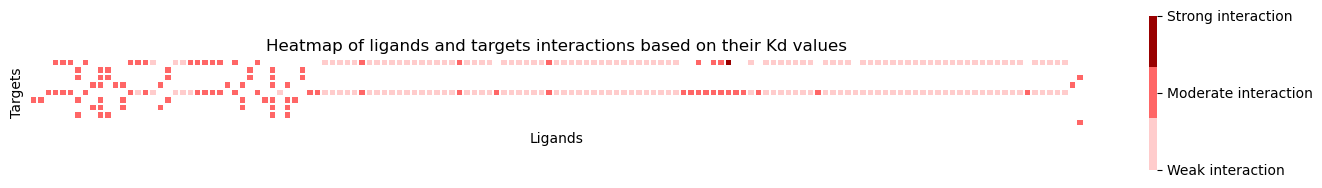

In [130]:
interaction_map(Kd_cleaned, 'Kd')

- **EC50**: We consider the interaction between the target (CDK) and the ligand to be: 
1) Strong if Kd < 10nM
2) Moderated if 10nM < Kd < 10'000nM
3) Weak if Kd > 10'000nM \
As EC50 is equal to 70nM for every proteins' interactions studied, we can make the assumption that the interaction is moderated for all of them. 